Test Accuracy: 67.19%
                precision    recall  f1-score   support

      Positive       0.67      0.76      0.71      1218
      Negative       0.65      0.61      0.63      1257
  Not_relevant       0.75      0.77      0.76      1312
Mixed Feelings       0.62      0.59      0.60      1238
       Neutral       0.67      0.63      0.65      1262

      accuracy                           0.67      6287
     macro avg       0.67      0.67      0.67      6287
  weighted avg       0.67      0.67      0.67      6287



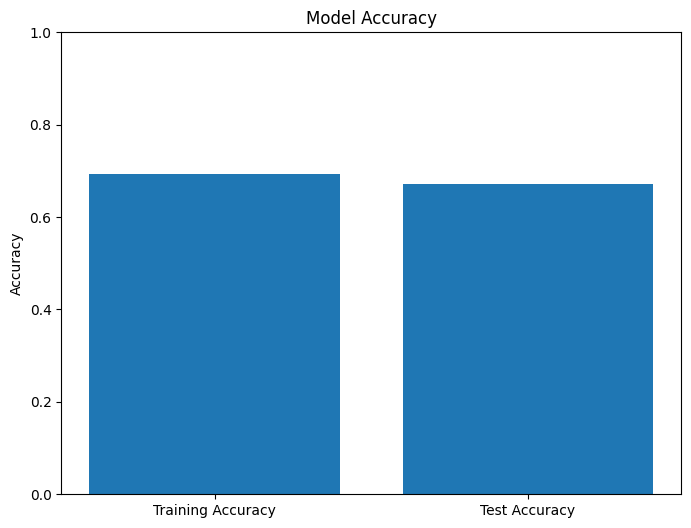

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.feature_extraction.text import TfidfVectorizer  # Import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt

# Load data from CSV
file_path = 'final_manglish_transliterated.csv'  # Replace with your file path
data = pd.read_csv(file_path)

# Ensure 'commentText' column contains strings
data['transliterated_text'] = data['transliterated_text'].astype(str)

# Function to convert sentiment labels to numerical values
sentiment_dict = {
    'Positive': 0,
    'Negative': 1,
    'Not_relevant': 2,
    'Mixed Feelings': 3,
    'Neutral': 4
}

data['Sentiment_Class'] = data['Sentiment_Class'].map(sentiment_dict)

# Tokenization and TF-IDF vectorization
max_words = 1000
max_seq_length = 100
vectorizer = TfidfVectorizer(max_features=max_words)  # Use TfidfVectorizer instead of CountVectorizer
X = vectorizer.fit_transform(data['transliterated_text'])
y = data['Sentiment_Class']

# Upsample minority classes to match the size of the majority class
data_upsampled = pd.concat([
    resample(data[data['Sentiment_Class'] == sentiment_dict['Positive']], replace=True, n_samples=len(data[data['Sentiment_Class'] == sentiment_dict['Not_relevant']])),
    resample(data[data['Sentiment_Class'] == sentiment_dict['Negative']], replace=True, n_samples=len(data[data['Sentiment_Class'] == sentiment_dict['Not_relevant']])),
    resample(data[data['Sentiment_Class'] == sentiment_dict['Not_relevant']], replace=True, n_samples=len(data[data['Sentiment_Class'] == sentiment_dict['Not_relevant']])),
    resample(data[data['Sentiment_Class'] == sentiment_dict['Mixed Feelings']], replace=True, n_samples=len(data[data['Sentiment_Class'] == sentiment_dict['Not_relevant']])),
    resample(data[data['Sentiment_Class'] == sentiment_dict['Neutral']], replace=True, n_samples=len(data[data['Sentiment_Class'] == sentiment_dict['Not_relevant']]))
])

# Tokenization and TF-IDF vectorization for balanced data
X_upsampled = vectorizer.fit_transform(data_upsampled['transliterated_text'])
y_upsampled = data_upsampled['Sentiment_Class']

# Split the upsampled data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_upsampled, y_upsampled, test_size=0.2, random_state=10)

# Build and train Multinomial Naive Bayes model
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)

# Evaluate the model on test data
y_pred = nb_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

# Generate predictions
reverse_sentiment_dict = {v: k for k, v in sentiment_dict.items()}
y_test_labels = [reverse_sentiment_dict[label] for label in y_test]
y_pred_labels = [reverse_sentiment_dict[label] for label in y_pred]

# Print complete classification report
print(classification_report(y_test_labels, y_pred_labels, target_names=sentiment_dict.keys()))

# Plotting the accuracy
plt.figure(figsize=(8, 6))
plt.bar(['Training Accuracy', 'Test Accuracy'], [accuracy_score(y_train, nb_model.predict(X_train)), accuracy])
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.ylim(0, 1)
plt.show()
